In [36]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

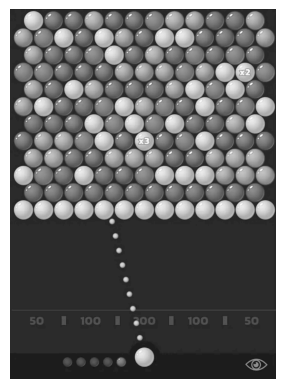

In [37]:
# Carga la imagen
ballscol = cv2.imread('../../IMAGES/practica2.1_kmeans_2.png', 1)
ballsc = cv2.cvtColor(ballscol, cv2.COLOR_BGR2RGB)

balls = cv2.imread('../../IMAGES/practica2.1_kmeans_2.png', 0)

plt.axis("off")
plt.imshow(balls, cmap='gray')

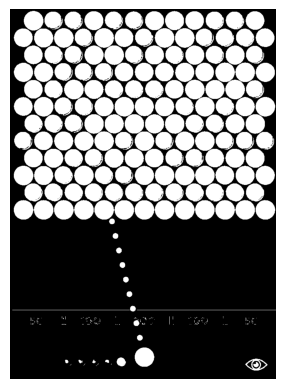

In [38]:
# Binarizacion
_, imgBin = cv2.threshold(balls, 84, 255, cv2.THRESH_BINARY)

plt.axis("off")
plt.imshow(imgBin, cmap='gray')

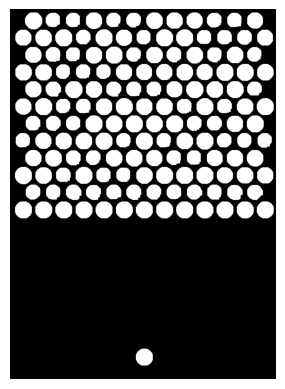

In [39]:
kernel = np.ones((5,5), np.uint8)

img_erosion = cv2.erode(imgBin, kernel, iterations=4)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=3)


plt.axis("off")
plt.imshow(img_dilation, cmap='gray')

(963, 693, 3)


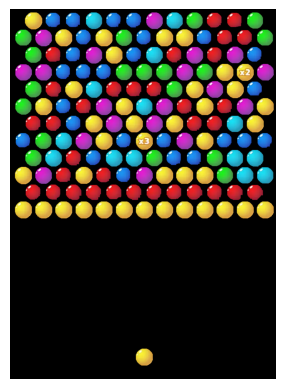

In [40]:
cv2.imwrite("../../IMAGES/piv.jpg", img_dilation)
img_dilation2 = cv2.imread('../../IMAGES/piv.jpg', 1)

masked3 = cv2.bitwise_and(img_dilation2, ballsc)

print(masked3.shape)

plt.axis("off")
plt.imshow(masked3, cmap='gray')

(192, 138, 3)


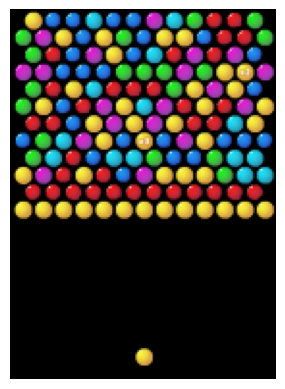

In [41]:
escala = 20

alto = int(masked3.shape[0]*escala/100)
ancho = int(masked3.shape[1]*escala/100)

newdim = (ancho,alto)

new = cv2.resize(masked3, newdim, interpolation=cv2.INTER_AREA)

print(new.shape)

plt.axis("off")
plt.imshow(new, cmap='gray')

masked3 = np.copy(new)

In [42]:
# Separar las imagenes en 3 canales
B, G, R = cv2.split(masked3)

# Convertir cada canal en arreglo
ArrayR = np.asarray(R)
ArrayG = np.asarray(G)
ArrayB = np.asarray(B)


vectorR = ArrayR.flatten()

vectorG = ArrayG.flatten()

vectorB = ArrayB.flatten()


print(vectorR)
print(vectorR.shape)

[0 0 0 ... 0 0 0]
(26496,)


In [43]:
column_nameR = ["R"]
column_nameG = ["G"]
column_nameB = ["B"]

data_R = pd.DataFrame(vectorR, columns=column_nameR)
data_G = pd.DataFrame(vectorG,columns=column_nameG)
data_B = pd.DataFrame(vectorB,columns=column_nameB)

result = pd.concat([data_R, data_G, data_B],axis=1)

result

,R,G,B
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
26491,0,0,0
26492,0,0,0
26493,0,0,0
26494,0,0,0


In [44]:
K=3

c1 = result.iloc[:,0]
c2 = result.iloc[:,1]
c3 = result.iloc[:,2]

In [45]:
import numpy as np

zero_min=np.min(c1)
zero_max=np.max(c1)

one_min=np.min(c2)
one_max=np.max(c2)

two_min=np.min(c3)
two_max=np.max(c3)

print(int(zero_min),int(zero_max))

0 249


In [46]:
np.random.seed(1500)

In [47]:
mu=[]
for i in range(0,K):
    zeros=np.random.randint(zero_min,zero_max)
    ones=np.random.randint(one_min,one_max)
    twos=np.random.randint(two_min,two_max)
    
    mu.append([zeros,ones,twos])

mu

[[19, 75, 193], [125, 110, 194], [169, 143, 147]]

In [48]:
r=np.zeros(result.shape[0]*K).reshape(result.shape[0],K)
pd.DataFrame(r).head()

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [49]:
plot_counter=0
J_plot=[]

for i in range(1,10): # Realizar el proceso máximo 10 veces
    J=0 # Medida de distorsión
    
    # Recorrer todos los elementos de la base de datos para ir guardando la clase a la que pertenece
    for n in range(0,result.shape[0]): 
        x=np.array(result.iloc[n,0:4])
        mins=[]

        for k in range(0,K):
            distance=np.linalg.norm(x-mu[k]) # Cálculo de distancia euclidiana
            mins.append(distance**2) # Guardar las distancias para despues elegir la menor

        k_r=np.argmin(np.array(mins)) # Se compara el valor minimo para obtener la posicion correspondiente a la clase
        r[n,k_r]=1 # Asignación de clases a cada elemento en ""r"
    
    # Calcula el valor de la medida de distorsión y guarda el valor de J en una lista para saber su valor actual y el previo
    for n in range(0,result.shape[0]):
        for k in range(0,K):
            distance=np.linalg.norm(x-mu[k])
            J=r[n,k]*(distance**2)+J
    J_plot.append(J)

    # Actualizar los centroides dentro de mu[]
    for k in range(0,K):
        count_1,count_2=0,0
        for n in range(0,result.shape[0]):
            x=np.array(result.iloc[n,0:4])
            count_1=r[n,k]*x+count_1
            count_2=r[n,k]+count_2
        mu[k]=count_1/count_2
        
    #print(J)
    
    # Termina el ciclo si J no tiene un cambio considerable con su valor previo
    if i>1 and abs(J-J_prev)<0.5:
        break
    J_prev=J
    plot_counter=1+plot_counter

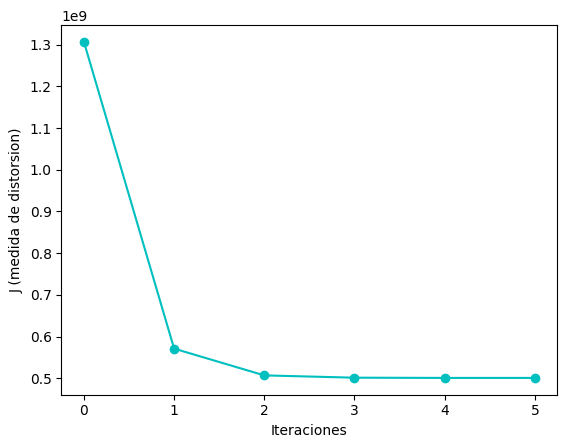

In [50]:
import matplotlib.pyplot as plt

plt.plot(J_plot,linestyle='-', marker='o',color='c')
plt.ylabel('J (medida de distorsion)')
plt.xlabel('Iteraciones')
plt.show()

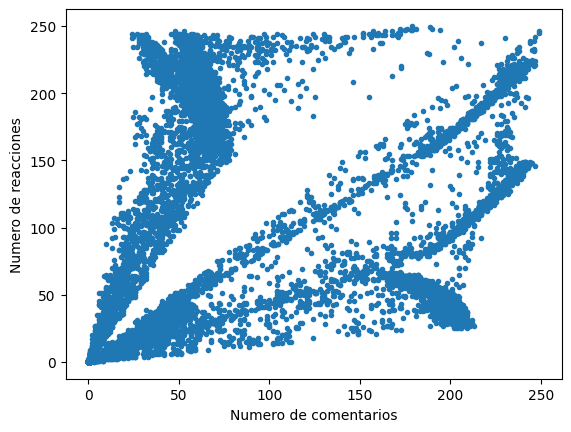

In [51]:
plt.scatter(c1,c2,marker='.')
plt.ylabel('Numero de reacciones')
plt.xlabel('Numero de comentarios')
plt.show()

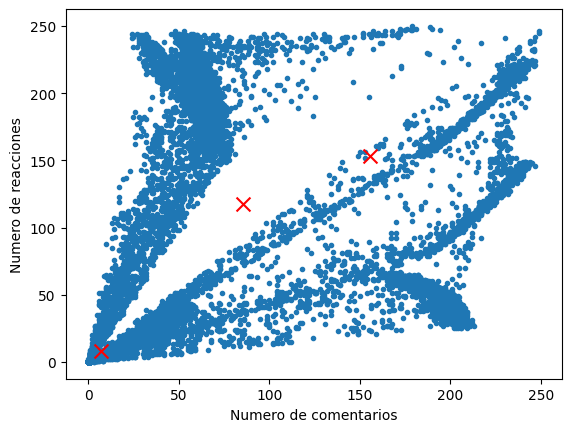

In [52]:
mu=pd.DataFrame(mu)
plt.scatter(c1,c2,marker='.')
plt.scatter(mu[0],mu[1],s=100,marker='x',color='red')
plt.ylabel('Numero de reacciones')
plt.xlabel('Numero de comentarios')
plt.show()

In [53]:
r_new=[]
for row in r:
    r_new.append(np.argmax(row)+1)

nueva = pd.DataFrame(r_new)

resultado = pd.concat([result,nueva],axis=1)
resultado.head()

,R,G,B,0
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


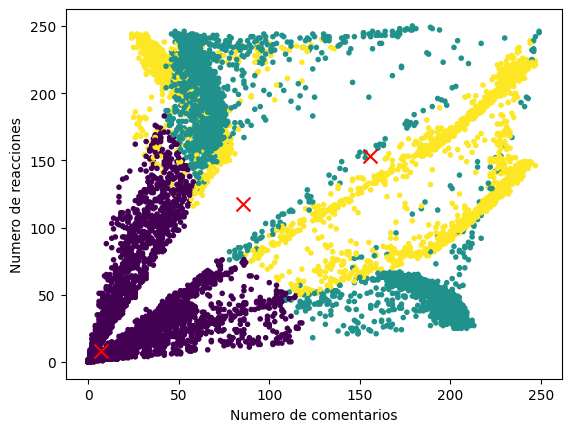

In [54]:
plt.scatter(c1,c2,c=resultado.iloc[:,3],marker='.')
plt.scatter(mu[0],mu[1],s=100,marker='x',color='red')
plt.ylabel('Numero de reacciones')
plt.xlabel('Numero de comentarios')
plt.show()

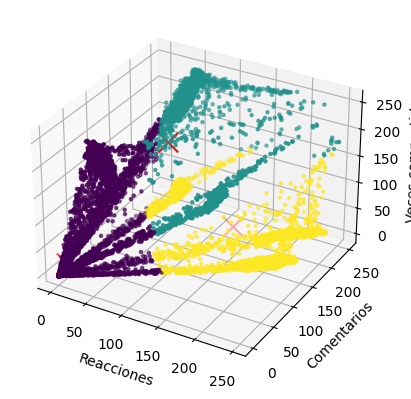

In [55]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 =c1
y1 =c2
z1 =c3

x2=mu[0]
y2=mu[1]
z2=mu[2]

ax.scatter(x1, y1, z1, c=resultado.iloc[:,3], marker='.')
ax.scatter(x2, y2, z2, c='red', s=200, marker='x')

ax.set_xlabel('Reacciones')
ax.set_ylabel('Comentarios')
ax.set_zlabel('Veces compartido')

plt.show()